In [1]:
import re
import json
from typing import Annotated, List, Dict, Any, Literal, Optional
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
import uuid
from datetime import datetime

In [2]:
call_stack = []

In [3]:
llm = ChatOllama(model="qwen3:4b", temperature=0)

In [4]:
class HumanFeedback(BaseModel):
    """Structure for human feedback"""
    feedback_id: str = Field(default_factory=lambda: str(uuid.uuid4()))
    task_id: str
    feedback_content: str
    approval_status: Literal["approved", "rejected", "needs_revision"] = "needs_revision"
    #priority: Literal["low", "medium", "high"] = "medium"
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())

class TaskState(TypedDict):
    """State for the HITL system"""
    messages: Annotated[List[Any], "Messages in the conversation"]
    task_description: str
    task_id: str
    current_step: str
    agent_response: str
    human_feedback: Optional[HumanFeedback]
    final_output: str
    requires_human_input: bool
    human_decision: Literal["approve", "revise", "reject", "continue"]
    revision_count: int


In [5]:
class StripThinkParser(StrOutputParser):
    """Remove <think>...</think> sections if they exist"""
    def parse(self, text: str) -> str:
        cleaned = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
        # Also handle [think]...[/think] variations
        cleaned = re.sub(r"\[think\].*?\[/think\]", "", cleaned, flags=re.DOTALL)
        # Remove extra whitespace
        cleaned = re.sub(r"\n\s*\n", "\n\n", cleaned)
        call_stack.append(f"StripThinkParser.parse: Removed thinking tags from response")
        return cleaned.strip()
strip_think_parser = StripThinkParser()

In [6]:
def task_analysis_node(state: TaskState) -> Dict[str, Any]:
    """Analyze the task and determine if human input is needed"""
    call_stack.append("task_analysis_node: Analyzing task requirements")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Task Analysis Specialist.
        Analyze the given task and determine if it requires human oversight.
        
        Consider these factors:
        - Financial implications
        - Ethical considerations
        - Legal requirements
        - Creative decisions
        - Safety concerns
        - Complex judgment calls
        
        Respond with a JSON object:
        {{
          "analysis": "Brief analysis of why human input is or isn't needed",
          "requires_human_input": true/false,
          "reasoning": "Explanation of your decision"
        }}
        
        Use <think> tags for your analysis process."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | strip_think_parser
    analysis_response = chain.invoke({"task": state["task_description"]})
    
    # Try to parse as JSON
    try:
        analysis_data = json.loads(analysis_response)
        requires_human = analysis_data.get("requires_human_input", False)
        analysis_text = analysis_data.get("analysis", analysis_response)
    except:
        # Fallback if JSON parsing fails
        requires_human = "human" in analysis_response.lower() or "approval" in analysis_response.lower()
        analysis_text = analysis_response
    
    return {
        "agent_response": analysis_text,
        "requires_human_input": requires_human,
        "current_step": "human_review" if requires_human else "task_execution"
    }

In [7]:
def task_execution_node(state: TaskState) -> Dict[str, Any]:
    """Execute the task when no human input is required"""
    call_stack.append("task_execution_node: Executing task autonomously")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Task Execution Specialist.
        Complete the given task to the best of your ability.
        Provide a comprehensive, well-structured response.
        
        Use <think> tags for your planning and execution process."""),
        ("user", "Task: {task}")
    ])
    
    chain = prompt | llm | strip_think_parser
    execution_response = chain.invoke({"task": state["task_description"]})
    
    return {
        "agent_response": execution_response,
        "current_step": "final_review"
    }

In [8]:
def human_interface_node(state: TaskState) -> Dict[str, Any]:
    """Interface for human interaction - actually requests human input"""
    call_stack.append("human_interface_node: Requesting human input")
    
    print("\n" + "="*50)
    print("HUMAN-IN-THE-LOOP INTERACTION REQUIRED")
    print("="*50)
    print(f"Task: {state['task_description']}")
    print(f"Agent Analysis: {state['agent_response']}")
    print("="*50)
    
    # Actually request human input
    print("\nPlease provide your feedback on this task analysis:")
    feedback_content = input("Your feedback: ")
    
    print("\nWhat is your approval status?")
    print("1. Approved")
    print("2. Rejected")
    print("3. Needs Revision")
    
    approval_choice = input("Enter choice (1/2/3): ")
    approval_map = {"1": "approved", "2": "rejected", "3": "needs_revision"}
    approval_status = approval_map.get(approval_choice, "needs_revision")
    
    
    print("="*50 + "\n")
    
    # Create human feedback object
    human_feedback = HumanFeedback(
        task_id=state["task_id"],
        feedback_content=feedback_content,
        approval_status=approval_status
    )
    
    # Determine next step based on feedback
    if approval_status == "approved":
        next_step = "task_execution_with_guidance"
        human_decision = "approve"
    elif approval_status == "rejected":
        next_step = "final_review"
        human_decision = "reject"
    else:  # needs_revision
        next_step = "task_revision"
        human_decision = "revise"
    
    return {
        "human_feedback": human_feedback.model_dump(),
        "current_step": next_step,
        "human_decision": human_decision
    }

In [9]:
def task_revision_node(state: TaskState) -> Dict[str, Any]:
    """Revise the task based on human feedback"""
    call_stack.append("task_revision_node: Revising task based on human feedback")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Task Revision Specialist.
        Revise your approach based on the human feedback provided.
        
        Consider all feedback points and adjust your solution accordingly.
        Explain how you've addressed each piece of feedback.
        
        Use <think> tags for your revision planning process."""),
        ("user", "Original Task: {task}\n\nHuman Feedback: {feedback}\n\nRevise your approach:")
    ])
    
    chain = prompt | llm | strip_think_parser
    revision_response = chain.invoke({
        "task": state["task_description"],
        "feedback": state["human_feedback"]["feedback_content"] if state["human_feedback"] else "No feedback provided"
    })
    
    revision_count = state.get("revision_count", 0) + 1
    
    return {
        "agent_response": revision_response,
        "revision_count": revision_count,
        "current_step": "task_execution_with_guidance"
    }


In [10]:
def guided_execution_node(state: TaskState) -> Dict[str, Any]:
    """Execute the task with human guidance incorporated"""
    call_stack.append("guided_execution_node: Executing task with human guidance")
    
    human_feedback_content = state["human_feedback"]["feedback_content"] if state["human_feedback"] else "No specific guidance"
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Guided Task Execution Specialist.
        Complete the task incorporating the human feedback and guidance.
        Ensure you've addressed all concerns raised in the feedback.
        
        Use <think> tags for your execution process."""),
        ("user", "Task: {task}\n\nHuman Guidance: {guidance}")
    ])
    
    chain = prompt | llm | strip_think_parser
    execution_response = chain.invoke({
        "task": state["task_description"],
        "guidance": human_feedback_content
    })
    
    return {
        "agent_response": execution_response,
        "current_step": "final_review"
    }

In [11]:
def final_review_node(state: TaskState) -> Dict[str, Any]:
    """Final review and output preparation"""
    call_stack.append("final_review_node: Preparing final output")
    
    # Determine the source of the final content
    final_content = state["agent_response"]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Final Review Specialist.
        Prepare the final output for delivery.
        Ensure it's complete, well-formatted, and addresses the original task.
        If this was reviewed by a human, confirm that human feedback was incorporated.
        
        Use <think> tags for your review process."""),
        ("user", "Task: {task}\n\nProposed Solution: {solution}")
    ])
    
    chain = prompt | llm | strip_think_parser
    review_response = chain.invoke({
        "task": state["task_description"],
        "solution": final_content
    })
    
    return {
        "final_output": review_response,
        "current_step": "end"
    }


In [12]:
def hitl_router(state: TaskState) -> str:
    """Route to the appropriate node based on current step and human decision"""
    call_stack.append(f"hitl_router: Routing based on step '{state['current_step']}'")
    return state["current_step"]


In [13]:
from langgraph.graph import StateGraph, END, START

builder = StateGraph(TaskState)

# Add nodes
builder.add_node("analyze", task_analysis_node)
builder.add_node("execute", task_execution_node)
builder.add_node("human_review", human_interface_node)
builder.add_node("revise", task_revision_node)
builder.add_node("guided_execute", guided_execution_node)
builder.add_node("finalize", final_review_node)

# Add edges
builder.add_edge(START, "analyze")
builder.add_conditional_edges(
    "analyze",
    hitl_router,
    {
        "human_review": "human_review",
        "task_execution": "execute"
    }
)
builder.add_conditional_edges(
    "human_review",
    hitl_router,
    {
        "task_execution_with_guidance": "guided_execute",
        "task_revision": "revise",
        "final_review": "finalize"  # If rejected outright
    }
)
builder.add_edge("execute", "finalize")
builder.add_edge("revise", "guided_execute")
builder.add_edge("guided_execute", "finalize")
builder.add_edge("finalize", END)

# Compile the graph
hitl_system = builder.compile()

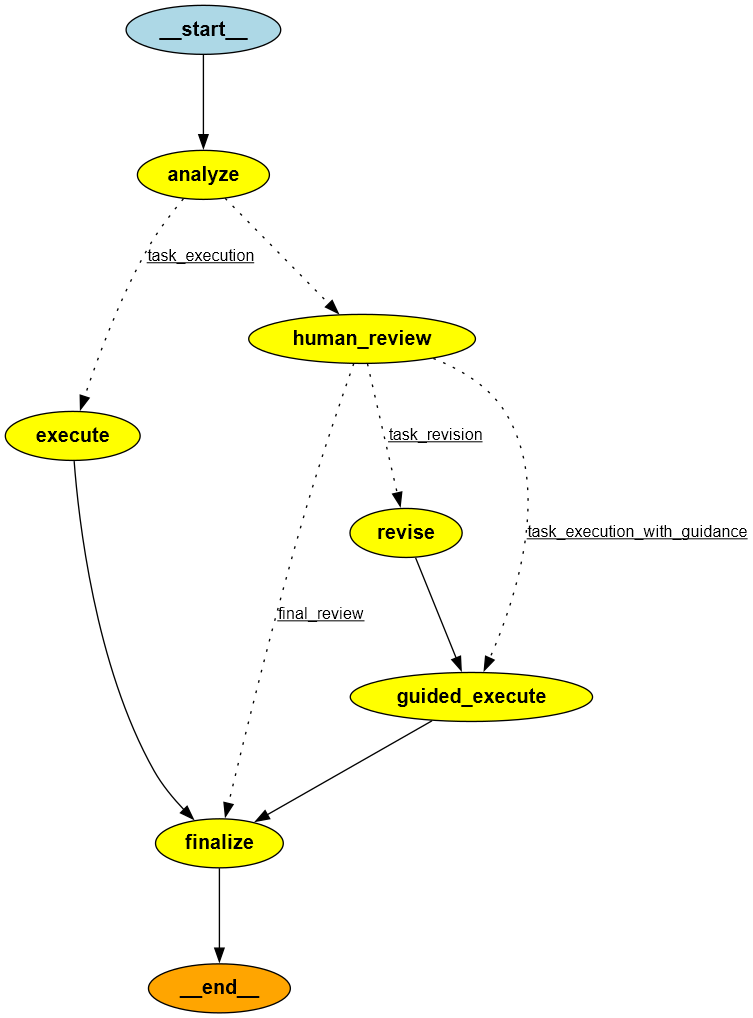

In [14]:
from IPython.display import Image, display
display(Image(hitl_system.get_graph().draw_png()))

In [15]:
def run_hitl_system(task: str) -> Dict[str, Any]:
    """Run the Human-in-the-Loop system with a task"""
    # Clear call stack for new execution
    global call_stack
    call_stack = []
    call_stack.append("run_hitl_system: Starting execution")
    
    task_id = str(uuid.uuid4())
    
    initial_state = TaskState(
        messages=[HumanMessage(content=task)],
        task_description=task,
        task_id=task_id,
        current_step="analyze",
        agent_response="",
        human_feedback=None,
        final_output="",
        requires_human_input=False,
        human_decision="continue",
        revision_count=0
    )
    
    result = hitl_system.invoke(initial_state)
    
    # Format the output for clarity
    output = {
        "task": task,
        "task_id": task_id,
        "final_output": result["final_output"],
        "required_human_input": result["requires_human_input"],
        "human_feedback": result["human_feedback"],
        "execution_trace": call_stack.copy(),
        "revision_count": result["revision_count"]
    }
    
    call_stack.append("run_hitl_system: Execution completed")
    return output

In [17]:
# Example 1: Task that requires human input
print("Example 1: Task requiring human oversight")
task1 = "Draft a public apology statement for a company data breach that affected 100,000 customers"
result1 = run_hitl_system(task1)

print(f"Task: {result1['task']}")
print(f"Required Human Input: {result1['required_human_input']}")
print(f"Revisions: {result1['revision_count']}")
print(f"Final Output: {result1['final_output'][:300]}...")

if result1['human_feedback']:
    print(f"Human Feedback: {result1['human_feedback']['feedback_content']}")
    print(f"Approval Status: {result1['human_feedback']['approval_status']}")

print("\nExecution Trace:")
for step in result1['execution_trace'][-5:]:  # Show last 5 steps
    print(f"  - {step}")

print("\n" + "="*60 + "\n")

Example 1: Task requiring human oversight

HUMAN-IN-THE-LOOP INTERACTION REQUIRED
Task: Draft a public apology statement for a company data breach that affected 100,000 customers
Agent Analysis: The task requires a public apology statement for a data breach, which involves ethical, legal, and emotional considerations. Human oversight is necessary to ensure the tone is appropriate, legally compliant, and empathetic to affected customers.

Please provide your feedback on this task analysis:

What is your approval status?
1. Approved
2. Rejected
3. Needs Revision

Task: Draft a public apology statement for a company data breach that affected 100,000 customers
Required Human Input: True
Revisions: 1
Final Output: **Final Review: Public Apology Statement for Data Breach**  

**To Our Valued Customers,**  

We are deeply sorry to inform you of a data breach that affected 100,000 of our customers. This is a serious matter, and we take full responsibility for the incident. We understand the fr

In [18]:
# Example 2: Task that can be handled autonomously
print("Example 2: Task handled autonomously")
task2 = "Calculate the compound interest on $10,000 invested for 5 years at 3% annual rate"
result2 = run_hitl_system(task2)

print(f"Task: {result2['task']}")
print(f"Required Human Input: {result2['required_human_input']}")
print(f"Revisions: {result2['revision_count']}")
print(f"Final Output: {result2['final_output']}")

print("\nExecution Trace:")
for step in result2['execution_trace'][-5:]:  # Show last 5 steps
    print(f"  - {step}")

print("\n" + "="*60 + "\n")

Example 2: Task handled autonomously
Task: Calculate the compound interest on $10,000 invested for 5 years at 3% annual rate
Required Human Input: False
Revisions: 0
Final Output: </think>

$$
A = P \left(1 + \frac{r}{n}\right)^{nt}
$$

Where:
- $ P = \$10,000 $ (principal),
- $ r = 3\% = 0.03 $ (annual interest rate),
- $ t = 5 $ years,
- $ n = 1 $ (compounded annually).

### Step-by-Step Calculation:
1. **Calculate the growth factor**:
   $$
   \left(1 + \frac{0.03}{1}\right)^{1 \times 5} = (1.03)^5
   $$

2. **Compute $ (1.03)^5 $**:
   - $ (1.03)^1 = 1.03 $
   - $ (1.03)^2 = 1.0609 $
   - $ (1.03)^3 = 1.092727 $
   - $ (1.03)^4 = 1.12550881 $
   - $ (1.03)^5 = 1.1592740743 $

3. **Calculate the total amount**:
   $$
   A = 10,000 \times 1.1592740743 \approx \$11,592.74
   $$

4. **Determine the compound interest**:
   $$
   \text{Interest} = A - P = 11,592.74 - 10,000 = \$1,592.74
   $$

### Final Answer:
The compound interest earned over 5 years is **\$1,592.74**.

Execution Trace

In [19]:
# Example 3: Complex task requiring revision
print("Example 3: Task requiring revision based on feedback")
task3 = "Create a marketing campaign for a new eco-friendly product"
result3 = run_hitl_system(task3)

print(f"Task: {result3['task']}")
print(f"Required Human Input: {result3['required_human_input']}")
print(f"Revisions: {result3['revision_count']}")
print(f"Final Output: {result3['final_output'][:300]}...")

if result3['human_feedback']:
    print(f"Human Feedback: {result3['human_feedback']['feedback_content'][:100]}...")
    print(f"Approval Status: {result3['human_feedback']['approval_status']}")

print("\nExecution Trace:")
for step in result3['execution_trace'][-5:]:  # Show last 5 steps
    print(f"  - {step}")

Example 3: Task requiring revision based on feedback

HUMAN-IN-THE-LOOP INTERACTION REQUIRED
Task: Create a marketing campaign for a new eco-friendly product
Agent Analysis: The task involves creating a marketing campaign for an eco-friendly product, which requires careful consideration of ethical, legal, and creative aspects.

Please provide your feedback on this task analysis:

What is your approval status?
1. Approved
2. Rejected
3. Needs Revision

Task: Create a marketing campaign for a new eco-friendly product
Required Human Input: True
Revisions: 0
Final Output: **Final Review: "GreenFuture" Marketing Campaign**  

**1. Campaign Overview**  
- **Name:** "GreenFuture"  
- **Tagline:** "Sustainable Living, Simplified"  
- **Objective:** Promote eco-friendly product while emphasizing sustainability, innovation, and community impact.  

---

**2. Target Audienc...
Human Feedback: looks good...
Approval Status: approved

Execution Trace:
  - hitl_router: Routing based on step 'task_ex